# Tree Species Classifier
##### By: Hayes Hundman

This is the first notebook in a series which will document my learning process and I go through the FastAI [book](https://github.com/fastai/fastbook) and [online course](https://course.fast.ai/). This will mainly be for my learning experience and will focus on covering topics in the book and, more broadly, topics in deep learning. These notebooks will also feature quite a bit of code from the fastbook or is built upon it, so I highly recommend referencing that for any questions. The book goes into more depth than what I may cover, and another great source is the documentation for the fastai2 library, which also happens to be written in jupyter notebooks with example code. I will also be developing these notebooks on instances which have been made free to use and already set up with the fastbook code and data. This is made possible by [Paperspace](https://www.paperspace.com) where they have both free and paid instances, and you can find more about that on the fastai course website.

I have some experience with machine learning, deep learning, and statistics and I plan to build upon that experience with this series. I hope this may provide some basic examples for those also going through the course. If you see any mistakes feel free to let me know as this is a learning experience for me and feedback is always appreciated.

This notebook will cover image recognition. Specifically I plan on creating a classifier based on different tree species. The species are *Giant Redwood, Willow, Dragon Blood, Aspen, and Japanese Maple.*

In [1]:
#!pip install fastbook
#!pip install -q jmd_imagescraper
#!pip install xlrd

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

from pathlib import Path
from jmd_imagescraper.core import *

Above are the library installs and imports for this notebook. I mainly utilize fastai2 from the fastbook, and jmd_imagescraper to create my own dataset from a duckduckgo image scraper.

### Data Collection

In [4]:
species = ['Giant Redwood', 'Willow', 'Dragon Blood', 'Aspen', 'Japanese Maple']

In [5]:
path = Path().cwd()/"images"

In [6]:
#for tree in species:
    #duckduckgo_search(root, tree, tree+' tree', max_results=90, img_size = ImgSize.Large, img_type = ImgType.Photo)

Here I create my list of tree species which I will be classifying. I also create the path to where my images will be stored. Then for each tree species I get 90 images from duckduckgo that have the parameters, large images, and photos.

I found this duckduckgo method to be super useful from [Joe Dockrill](https://joedockrill.github.io/blog/projects/imagescraper/) on the [Fastai Forums](https://forums.fast.ai/). Fastai shows how to use both a bing and duckduckgo image scraper to collect images to make your own dataset. I found this method to be the most straight forward and it provided better results than bing.

In [7]:
from jmd_imagescraper.imagecleaner import *
display_image_cleaner(path)

HTML(value='<h2>No images left to display in this folder.</h2>', layout=Layout(visibility='hidden'))

GridBox(children=(VBox(children=(Image(value=b'', layout="Layout(width='150px')"), Button(description='Delete'…

In [8]:
fns = get_image_files(path)
#fns
failed = verify_images(fns)
#failed

In [9]:
#failed.map(Path.unlink);

After I download the images I can then go through all of them by class with a widget and delete any images which are incorrect or don't represent my chosen classes correctly. I also check to make sure all images are verified as sometimes the images do not open properly, and can drop any which have issues. It is **important** to highlight that data collection plays a crucial role in determining the ability of the model. In this project a lot of the images of trees take place during the spring, summer, or fall because you can see that they have their leaves for the most part. When training a model on data it is important to realize that the model needs as many examples as possible to perform well. For example my model would probably perform quite poorly on images of trees in the winter because my dataset contains very few examples of trees without leaves. This is a key aspect of deep learning, and because of this, usually more high quality data leads to better model performance. 

### Preparing the Data

In [10]:
trees = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

In [11]:
trees = trees.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = trees.dataloaders(path)

In [12]:
#trees.summary(path)

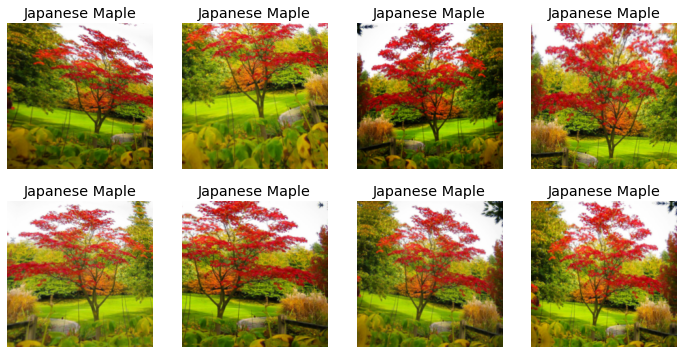

In [13]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Here I prepare the data by creating a datablock and then a dataloader. Fastai provides classes that abstract away many parts of the deep learning process, and sets many parameters to defaults that are based on the *state of the art* and generally just improve model performance. For preparing the data I create a *DataBlock* which takes image files and the folder names as labels. It then randomly splits the data into training and validation datasets and resizes all of the images to a specific size. It also makes the image a square if it is not. This is because when neural networks are processed a lot of matrix multiplications take place and they are processed more efficiently when they are squares(also when the dim is a multiple of 8). 

I then use the datablock to create a *Dataloader*. The dataloader controls the loading of batches and how the data is loaded. Deep learning training is much faster on GPUs vs CPUs and even faster on dedicated neural network chips. But generally most training is done today on a GPU and they have a limited amount of memory which can be used at any one time. The dataloader handles loading data and batches in the training process. I also provide it a set of data transformations.

Data transformations are used to help *create* more data from the existing dataset. This is done essentially by modifying and warping the original data through a set of [transformations](https://fastai1.fast.ai/vision.transform.html) some of which include, cropping, rotating, perspective shift, changing brightness, and more. The process of data augmentation improves generalization because neural networks have to be taught to generalize if an image is slightly tilted or dark. They don't inherently understand different perspectives, and to make the model robust to different images a variety of changes can be applied to the images.

### Training

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0010000000474974513)

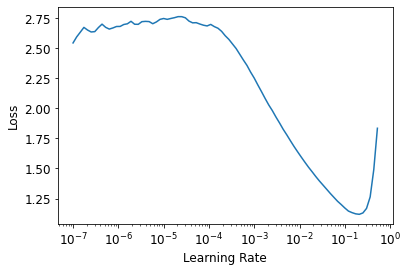

In [14]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

Now that the data has been prepared it is time to begin training. This first starts by choosing a model. Here I choose a [resnet34](https://arxiv.org/abs/1512.03385) model which the fastai library provides. It has already been trained on imagenet which is an image classifying dataset with thousands of images. I can then use transfer learning to borrow that trained model which has weights that work well on image classification and use it for my task with much less training required. But to train well we need a learning rate that performs well. When training a neural net we need to make small steps that lower the error. Jeremy has a good explanation in the book, but [here](https://towardsdatascience.com/gradient-descent-a-beginners-guide-fa0b5d0a1db8) is another intuitive explanation of gradient descent, which is the algorithm used to lower the model error. Fastai provides a method for finding a learning rate which *should* work well but generally test a few to see what works best. Here I chose 10^-3 because that is roughly the steepest point of the curve. Around 10^-4 or less, the model takes too long to improve(step is too small), and getting close to 10^-1 will cause the error to go back up by making too large of a step.

In [15]:
learn.fine_tune(4, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.784830,2.332851,0.684211,00:05


epoch,train_loss,valid_loss,error_rate,time
0,2.011760,1.372888,0.508772,00:05
1,1.731265,0.676886,0.192982,00:05
2,1.432042,0.424913,0.105263,00:06
3,1.216765,0.372978,0.087719,00:05


In [16]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=0.00015848931798245758)

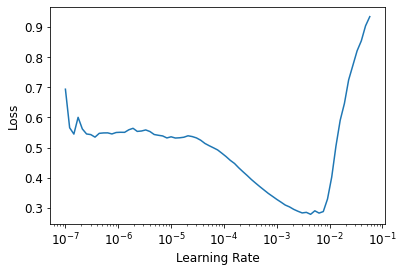

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(8, 2e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.594985,0.350756,0.105263,00:05
1,0.512400,0.289885,0.140351,00:05
2,0.405590,0.219249,0.087719,00:05
3,0.336126,0.224259,0.087719,00:05
4,0.278379,0.226383,0.087719,00:05
5,0.242147,0.205036,0.087719,00:05
6,0.213884,0.178929,0.052632,00:05
7,0.186777,0.173711,0.052632,00:05


I can then fine-tune the model. The fastai library when doing transfer learning will essentially throw out the last layer(or few layers) and retrain it on my specific tree data. This gives a decent score which is quick to train but to have a better model I *unfreeze* the rest of the model, find another good learning rate, and train the whole model this time. After a few epochs, you can see the *error rate*, or how many times the model is predicting the wrong class on the **validation data**. Note the validation loss and error rate are based on the validation data. This is another important part of deep learning but also applies to machine learning as a whole. This is because when training a model it is trained to get that data right, but we want the models to be able to generalize on data that the model has not yet seen. That is why validation data is never used in training, but it is used to test how well the model is generalizing to other similar data.

### Analyzing the Training

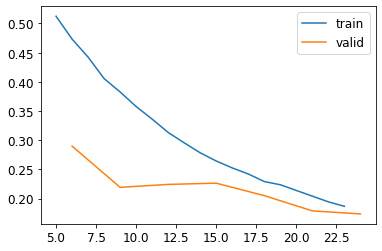

In [19]:
learn.recorder.plot_loss()

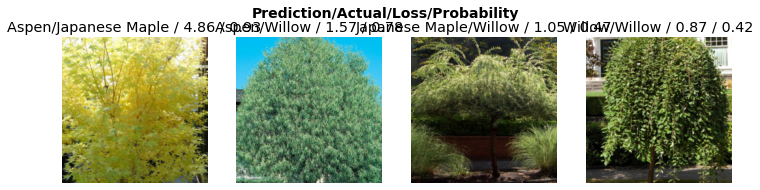

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, nrows=1)

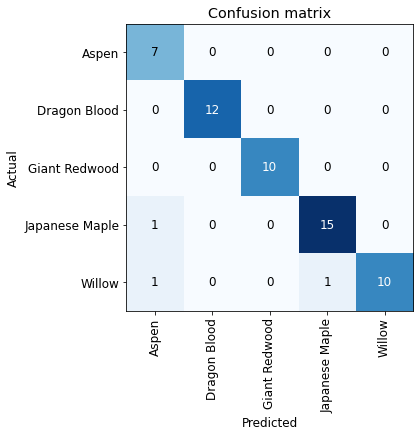

In [21]:
interp.plot_confusion_matrix(figsize=(6,6))

Now that I have trained the model it is important to analyze how well it is performing. Checking model performance helps deep learning practitioners understand what data the model is struggling on, if some data was missed, or if the model may have issues that are wrong ethically. Rachel Thomas is one of the instructors of the fastai course and has a great [blog](https://medium.com/@racheltho) which covers many of these topics. The fastbook also contains a chapter specifically dedicated to machine learning ethics.

But how well does my model appear to do? Well from just the validation loss and error rate it seems to perform quite well, classifying with ~95% accuracy. How good is that though? Generally when creating a model it is important to just do a simple test as a baseline to compare the model performance too. One example may be taking the average pixel value for each class and classifying images by which mean each image is closest to. Here I am not doing that, but there are other ways to see how a model is performing. First, as of quick note, it appears that the model is *underfitting* because the training loss is higher than the validation loss. Usually, it is better to slightly overfit than underfit so more training may be required or a change in learning rate. Another way to analyze the model is by displaying the images with the highest error. In this case, it was a Japanese Maple which was predicted to be a Aspen. This makes some sense as most Aspen tree images are taken during the fall when their leaves are yellow, and this Japanese maple also happens to look a little more yellow in this example. Diving into a model and looking at how the data performs, or even how different layers are being activated provide a way to see how the model works.

### Final Model

In [55]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(10, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,2.803740,1.952227,0.719298,00:05
1,1.938815,0.586987,0.210526,00:05
2,1.357492,0.252036,0.035088,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.196391,0.227272,0.035088,00:06
1,0.126666,0.249761,0.052632,00:06
2,0.104910,0.252375,0.052632,00:06
3,0.099719,0.168329,0.035088,00:06
4,0.087899,0.149689,0.035088,00:06
5,0.082182,0.130329,0.035088,00:06
6,0.069414,0.113938,0.035088,00:06
7,0.059903,0.106330,0.035088,00:06
8,0.057060,0.101490,0.035088,00:06
9,0.050097,0.091808,0.035088,00:06


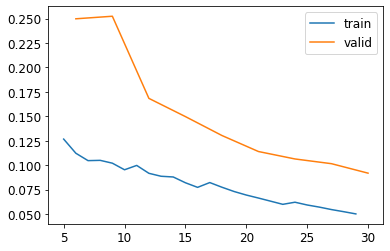

In [56]:
learn.recorder.plot_loss()

Finally, let's train the model again, but this time I will use a larger model to see if that helps with the underfitting as larger networks contain more parameters that can fit the data better. I also trained for more epochs until the validation loss no longer improved. There are many techniques developed for handling both overfitting and underfitting and the fastai library has many built-in. Here the final model improved from the previous. Further development may include additional techniques which I highlight below, acquiring more training data, increasing the image size, more data augmentations, or trying different hyperparameter tuning.

### More Advanced Training Techniques

The fastbook mentions a few more advanced training techniques for image classifiers. I will mention a few of them here but I would also suggest checking out the book or specific research papers which define these techniques.

**Data Normalization**
Data normalization refers to when your input data is normalized, which in this case refers to when the data has a mean of 0 and has a standard deviation of 1. Having normalized data can be important for both increasing train time and accuracy. Also, many models used for transfer learning have already been trained on data that is normalized, thus for optimal performance, one would also want their data to be normalized.

**Progressive Resizing**
Progressive resizing consists of changing the image size during training. This is generally done by starting with small images and over time increasing the size of the image. As is noted in the book this acts a lot like transfer learning where we take our model which was trained on smaller images and transfer those weights to a model that then trains on larger images. This is a good way of essentially taking your data and multiplying it because the model will be able to detect more and more detail from images that increase in resolution.

Data Normalization and Progressive Resizing are highlighted in the book along with [Mixup](https://arxiv.org/abs/1710.09412), Test Time Augmentation, and Label Smoothing. Additionally, optimizations in training is a highly active area of deep learning research and what I covered here probably is only a small subset of some common ones used.  